This file applies built-in MHA, no mask, non normalize Y

# HELPER FUNCTIONS

In [15]:
import numpy as np
import pickle
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Create dictionary of all unique paths
def path_encoder():
    path_sample = []
    for i in range(10):
        file_name =  f"Output/5by5_Data{i}"
        with open(file_name, "rb") as file:
            stat = pickle.load(file)
        path_sample.append(stat["data"]["paths_link"])

    all_path_link = [path_sample[i].values() for i in range(len(path_sample))]
    unique_values_set = {tuple(p) for path_set in all_path_link for path in path_set for p in path}
    path_set_dict = {v: k for k, v in enumerate(unique_values_set, start=1)}
    return path_set_dict

# Normalize tensor by Min-max scaling
def normalize(tensor):
    min_values = tf.reduce_min(tensor, axis=0)
    max_values = tf.reduce_max(tensor, axis=0)

    scaled_tensor = (tensor - min_values) / (max_values - min_values)
    mask = tf.equal(min_values, max_values)
    scaled_tensor = tf.where(mask, 1.0, scaled_tensor)
    return scaled_tensor

# def get_Link_Path_adj(net, path_encoded):
#     link_path = tf.zeros((net.shape[0], len(path_encoded)), dtype=tf.float32)
#     for p, index in path_encoded.items():
#         for link in p:
#             link_path = link_path.write(link, link_path.read(link).scatter(tf.IndexedSlices(1.0, [index-1])))
#     return link_path.stack()

def create_matrix(data, nodes):
    # data is an array, nodes is a set
    matrix = np.zeros((len(nodes), len(nodes)))
    for (o, d), v in data:
        o = int(o)
        d = int(d)
        matrix[o-1][d-1] = v
    return matrix

def create_single_tensor(data, nodes):
    matrix = create_matrix(data, nodes)
    tensor = tf.convert_to_tensor([matrix], dtype=tf.float32)
    tensor = tf.squeeze(tensor, axis=0)
    tensor = tf.reshape(tensor, [-1]) # Flatten the matrix to a 1D tensor
    tensor = tf.expand_dims(tensor, axis=1) # TensorShape([625, 1])
    return tensor

def get_graphTensor(network, nodes):
    cap = np.array(network[['init_node', 'term_node', 'capacity']].apply(lambda row: ((row['init_node'], row['term_node']), row['capacity']), axis=1).tolist(), dtype=object)
    length = np.array(network[['init_node', 'term_node', 'length']].apply(lambda row: ((row['init_node'], row['term_node']), row['length']), axis=1).tolist(), dtype=object)
    fft = np.array(network[['init_node', 'term_node', 'free_flow_time']].apply(lambda row: ((row['init_node'], row['term_node']), row['free_flow_time']), axis=1).tolist(), dtype=object)

    Cap = create_single_tensor(cap, nodes)
    Length = create_single_tensor(length, nodes)
    Fft = create_single_tensor(fft, nodes)
    tensor = tf.concat([tf.cast(Cap, tf.float32), tf.cast(Length, tf.float32), tf.cast(Fft, tf.float32)], axis=1)
    return tensor

def get_demandTensor(demand, nodes):
    tensor = np.array([(key, value) for key, value in demand.items()], dtype=object)
    tensor = create_single_tensor(tensor, nodes)
    return tensor

def get_pathTensor(path_links, nodes, path_encoded):
    paths = np.array([(key, [tuple(path) for path in value]) for key, value in path_links.items()], dtype=object)
    p1, p2, p3 = [], [], []
    for od, [path1, path2, path3] in paths:
        p1.append((od, path_encoded[path1]))
        p2.append((od, path_encoded[path2]))
        p3.append((od, path_encoded[path3]))

    p1 = create_single_tensor(p1, nodes)
    p2 = create_single_tensor(p2, nodes)
    p3 = create_single_tensor(p3, nodes)
    tensor = tf.concat([tf.cast(p1, tf.float32), tf.cast(p2, tf.float32), tf.cast(p3, tf.float32)], axis=1)
    return tensor

def get_flowTensor(demand, path_flows, nodes):
    flows = np.array([(k, v) for k, v in zip(demand.keys(), path_flows)], dtype=object)
    p1, p2, p3 = [], [], []
    for od, [path1, path2, path3] in flows:
        p1.append((od, path1))
        p2.append((od, path2))
        p3.append((od, path3))
    p1 = create_single_tensor(p1, nodes)
    p2 = create_single_tensor(p2, nodes)
    p3 = create_single_tensor(p3, nodes)
    tensor = tf.concat([tf.cast(p1, tf.float32), tf.cast(p2, tf.float32), tf.cast(p3, tf.float32)], axis=1)
    return tensor

def generate_xy(file_name, path_encoded):
    with open(file_name, "rb") as file:
        stat = pickle.load(file)

    path_links = stat["data"]["paths_link"]
    demand = stat["data"]["demand"]
    path_flows = stat["path_flow"]
    nodes = stat["data"]["nodes"]
    net = stat["data"]["network"]

    Graph = normalize(get_graphTensor(net, nodes))
    OD_demand = normalize(get_demandTensor(demand, nodes))
    Path_tensor = normalize(get_pathTensor(path_links, nodes, path_encoded))
    X = tf.concat([Graph, OD_demand, Path_tensor], axis=1)
    X = tf.where(tf.equal(X, 0), -1e9, X)

    # Get Y
    Flow_tensor = get_flowTensor(demand, path_flows, nodes)
    return X, Flow_tensor

def plot_loss(train_loss, val_loss, epochs):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validating Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# ATTENTION AND TRANSFORMER

In [16]:
import tensorflow as tf
from keras import layers as tfl
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, BatchNormalization

class EncoderLayer(tfl.Layer):
    def __init__(self, input_dim, d_model, heads, dropout, l2_reg):
        super().__init__()
        self.attn_layer = tfl.MultiHeadAttention(num_heads=heads, key_dim=d_model // heads, attention_axes=2)
        self.layer_norm1 = tfl.LayerNormalization()
        self.dense1 = tfl.Dense(d_model, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.dense2 = tfl.Dense(input_dim, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.dropout = tfl.Dropout(dropout)
        self.layer_norm2 = tfl.LayerNormalization()
        self.batch_norm = BatchNormalization()

    def call(self, x):
        attn_output = self.attn_layer(query=x, key=x, value=x, return_attention_scores=False)
        x = self.layer_norm1(x + self.dropout(attn_output))

        ffn_output = self.dense2(self.dropout(self.dense1(x)))
        x = self.layer_norm2(x + ffn_output)
        x = self.batch_norm(x)
        return x

class Encoder(tfl.Layer):
    def __init__(self, input_dim, d_model, N, heads, dropout, l2_reg=0.1):
        super().__init__()
        self.layers = [EncoderLayer(input_dim, d_model, heads, dropout, l2_reg) for _ in range(N)]
        self.dense = tfl.Dense(3, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    def call(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        return self.dense(output)

class DecoderLayer(tfl.Layer):
    def __init__(self, output_dim, d_model, heads, dropout, l2_reg):
        super().__init__()
        self.mha1 = tfl.MultiHeadAttention(num_heads=heads, key_dim=d_model // heads, attention_axes=2)
        self.layer_norm1 = tfl.LayerNormalization()
        self.mha2 = tfl.MultiHeadAttention(num_heads=heads, key_dim=d_model // heads, attention_axes=2)
        self.layer_norm2 = tfl.LayerNormalization()
        self.dense1 = tfl.Dense(d_model, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.dense3 = tfl.Dense(output_dim, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.layer_norm3 = tfl.LayerNormalization()
        self.dropout1 = tfl.Dropout(dropout)
        self.dropout2 = tfl.Dropout(dropout)
        self.dropout3 = tfl.Dropout(dropout)
        self.batch_norm = BatchNormalization()

    def call(self, x, encoder_output):
        attn1 = self.mha1(query=x, key=x, value=x, return_attention_scores=False)
        x = self.layer_norm1(x + self.dropout1(attn1))

        attn2 = self.mha2(query=x, key=encoder_output, value=encoder_output, return_attention_scores=False)
        x = self.layer_norm2(x + self.dropout2(attn2))
        ffn_output = self.dense3(self.dropout3(self.dense1(x)))
        x = self.layer_norm3(x + ffn_output)
        x = self.batch_norm(x)
        return x

class Decoder(tfl.Layer):
    def __init__(self, output_dim, d_model, N, heads, dropout, l2_reg=0.1):
        super().__init__()
        self.layers = [DecoderLayer(output_dim, d_model, heads, dropout, l2_reg) for _ in range(N)]

    def call(self, x, encoder_output):
        output = x
        for layer in self.layers:
            output = layer(output, encoder_output)
        return output

class Transformer(tfl.Layer):
    def __init__(self, input_dim, output_dim, d_model, E_layer, D_layer, heads, dropout):
        super().__init__()
        self.encoder = Encoder(input_dim, d_model, E_layer, heads, dropout)
        self.decoder = Decoder(output_dim, d_model, D_layer, heads, dropout)

    def call(self, x, y):
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(y, encoder_output)
        return decoder_output

    def eval(self):
        for layer in self.encoder.layers:
            layer.trainable = False
        for layer in self.decoder.layers:
            layer.trainable = False

    def train(self):
        for layer in self.encoder.layers:
            layer.trainable = True
        for layer in self.decoder.layers:
            layer.trainable = True

    def compile(self, train_data_loader, val_data_loader, optimizer, loss_fn, epochs, device):
        # Define the early stopping callback
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1,
            mode='min',
            restore_best_weights=True
        )
        train_losses = []
        val_losses = []
        with tqdm(total=epochs, unit="epoch") as pbar:
            for epoch in range(epochs):
                # Training phase
                self.train()
                total_train_loss = 0
                for src, trg in train_data_loader:
                    with tf.device(device):
                        with tf.GradientTape() as tape:
                            output = self.call(src, trg)
                            loss = loss_fn(trg, output)

                        # Backpropagate and update the model
                        gradients = tape.gradient(loss, self.trainable_variables)
                        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
                        total_train_loss += loss.numpy()
                        pbar.set_description(f"Train Loss: {total_train_loss / len(train_data_loader):.4f}")

                # Validation phase
                self.eval()
                total_val_loss = 0
                for src, trg in val_data_loader:
                    with tf.device(device):
                        output = self.call(src, trg)
                        loss = loss_fn(trg, output)
                        total_val_loss += loss.numpy()

                        pbar.set_description(f"Val Loss: {total_val_loss / len(val_data_loader):.4f}")

                pbar.update(1)
                train_losses.append(total_train_loss / len(train_data_loader))
                val_losses.append(total_val_loss / len(val_data_loader))
                print(f"Epoch: {epoch+1} - Train Loss: {total_train_loss/len(train_data_loader):.4f}, Val Loss: {total_val_loss/len(val_data_loader):.4f}")

                # Check for early stopping
                if early_stopping.model is not None:
                    early_stopping.on_epoch_end(epoch, {'val_loss': total_val_loss / len(val_data_loader)})
                    if early_stopping.stopped_epoch > 0:
                        print(f"Early stopping triggered at epoch {early_stopping.stopped_epoch + 1}")
                        break
        return self, train_losses, val_losses


# CREATE DATASET

In [3]:
class Dataset:
    def __init__(self, size, start_from=0):
        self.path_encoded = path_encoder()  # Get path encode dictionary
        self.X = []
        self.Y = []

        for i in tqdm(range(size)):
            file_name = f"Output/5by5_Data{start_from+i}"
            x, y = generate_xy(file_name, self.path_encoded)
            self.X.append(x)
            self.Y.append(y)

        self.X = tf.stack(self.X, axis=0)
        self.Y = tf.stack(self.Y, axis=0)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def to_tf_dataset(self, batch_size):
        dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y))
        dataset = dataset.shuffle(buffer_size=len(self.X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset


In [ ]:
# %run helpers.py
# Max 17000 files
batch_size = 256
data_size = 40000
train_size = int(data_size * 0.7)
val_size = int(data_size * 0.2)
test_size = data_size - train_size - val_size

train_dataset = Dataset(train_size)
train_data_loader = train_dataset.to_tf_dataset(batch_size)

val_dataset = Dataset(val_size, start_from=train_size)
val_data_loader = val_dataset.to_tf_dataset(batch_size)

test_dataset = Dataset(test_size, start_from=train_size+val_size)
test_data_loader = test_dataset.to_tf_dataset(batch_size)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import time
from tensorflow.keras.optimizers.schedules import ExponentialDecay

device = 'gpu'
input_dim = 7
output_dim = 3
d_model = 128
E_layer = 2
D_layer = 2
epochs = 120
initial_learning_rate = 0.002
# lr_schedule = ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=10000,
#     decay_rate=0.9,
#     staircase=True
# )
heads=4
dropout=0.5

model = Transformer(input_dim=input_dim, output_dim=output_dim,
                    d_model=d_model, E_layer=E_layer, D_layer=D_layer,
                    heads=heads, dropout=dropout)
loss_fn = MeanSquaredError()
optimizer = Adam(learning_rate=initial_learning_rate, clipvalue=1.0)

start = time.time()
model, train_loss, val_loss = model.compile(train_data_loader, val_data_loader, optimizer, loss_fn, epochs, device)
end = time.time()
train_time = end-start

  0%|          | 0/120 [00:00<?, ?epoch/s]

Epoch: 1 - Train Loss: 123475.1915, Val Loss: 125341.6120
Epoch: 2 - Train Loss: 123275.4389, Val Loss: 125362.8808
Epoch: 3 - Train Loss: 123048.9196, Val Loss: 124984.3895
Epoch: 4 - Train Loss: 122783.1348, Val Loss: 124823.0000
Epoch: 5 - Train Loss: 122490.2093, Val Loss: 124556.0799
Epoch: 6 - Train Loss: 122165.4818, Val Loss: 124226.1224
Epoch: 7 - Train Loss: 121820.7011, Val Loss: 123750.9624
Epoch: 8 - Train Loss: 121439.3591, Val Loss: 123302.7341
Epoch: 9 - Train Loss: 121030.4246, Val Loss: 122907.8637
Epoch: 10 - Train Loss: 120603.3140, Val Loss: 122382.9259
Epoch: 11 - Train Loss: 120143.0522, Val Loss: 122006.4899
Epoch: 12 - Train Loss: 119655.5410, Val Loss: 121343.9239
Epoch: 13 - Train Loss: 119147.4026, Val Loss: 120836.6670
Epoch: 14 - Train Loss: 118619.3067, Val Loss: 120530.0512
Epoch: 15 - Train Loss: 118069.8587, Val Loss: 119706.7758
Epoch: 16 - Train Loss: 117500.3764, Val Loss: 119206.3733
Epoch: 17 - Train Loss: 116903.7230, Val Loss: 118872.0503
Epoch:

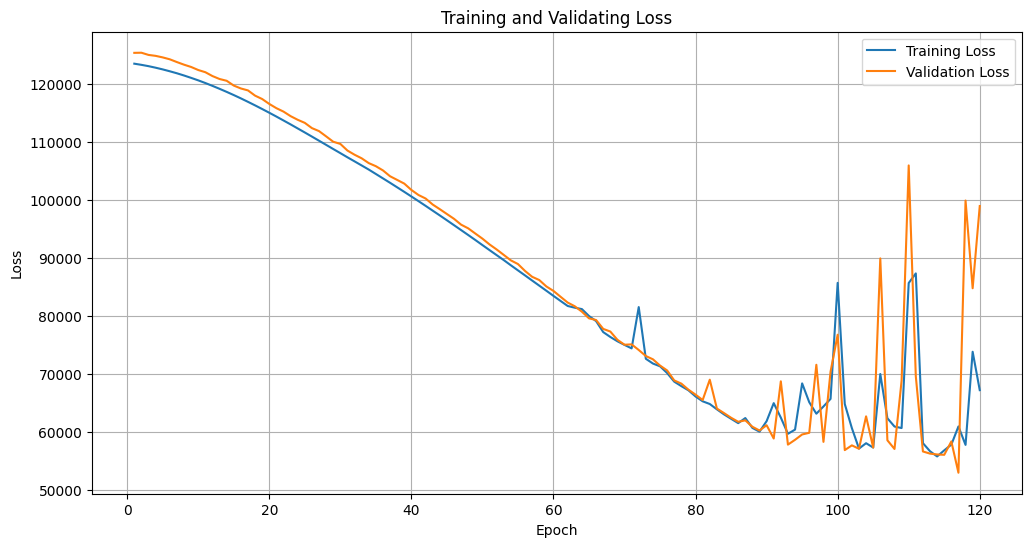

In [6]:
plot_loss(train_loss, val_loss, epochs)

# CHECK DELAY OF PREDICTED VALUES

In [11]:
def evaluate_model_withScaler(model, test_data_loader, device):
    model.eval()
    true_values = []
    predicted_values = []
    for src, trg in test_data_loader:
        model.eval()
        with tf.device(device):
            output = model(src, trg)
            mask = tf.expand_dims(tf.sign(tf.reduce_sum(tf.abs(trg), axis=-1)),-1)
            mask = tf.cast(mask, dtype=output.dtype)
            output = output * mask
            true_values.append(trg)
            predicted_values.append(output)

    return true_values, predicted_values

trg_origin, pred_tensor = evaluate_model_withScaler(model, test_data_loader, device)
all_tensors = []
for pred in pred_tensor:
    for sub_tensor in pred:
        all_tensors.append(sub_tensor)

In [12]:
import numpy as np
%run tf_helpers.py

base_path = 'Output/5by5_Data'
start_from=train_size+val_size
files = []
for i in range(200):
    file_name = ''.join([base_path, str(start_from+i)])
    files.append(file_name)

Avg_delay, Len_origin, Len_pred, Nan_num = [], [], [], []
for i, filename in tqdm(zip(all_tensors[:200], files), total=len(files)):
    avg_delay, len_origin, len_pred, nan_num = single_avg_delay(i, filename)
    Avg_delay.append(avg_delay)
    Len_origin.append(len_origin)
    Len_pred.append(len_pred)
    Nan_num.append(nan_num)

df = pd.DataFrame({
    'origin_od_pair': Len_origin,
    'pred_od_pair': Len_pred,
    'nan_percentage': Nan_num,
    'avg_delay': Avg_delay
})
df.to_csv("predicted_result.csv")
print("Average delay", round(np.mean(df['avg_delay']),4), "mins")

  0%|          | 0/200 [00:00<?, ?it/s]

Average delay -0.0152 mins
